# GEV6135 Assignment 7: Pytorch Autograd and NN

Before we start, please put your name, ID number, option (and your group members', if any) in following format: e.g., <br>
```
name = 'Kibok Lee'
idnum = '2022123456'
option = 1
group = {
    '2022123457': 'Alice Ahn',
    '2022123458': 'Bob Bae',
    '2022123459': 'Carol Choi',
}
```

In [29]:
# TODO: Put your name, id number, option (and your group members', if any):
# option 1: You did your assignment yourself.
# option 2: You didn't do your assignment yourself,
#           but you added your own comment to show your understanding.
name = ''
idnum = ''
option = 1
group = {}

# [torch.autograd](https://pytorch.org/docs/stable/autograd.html) and [torch.nn](https://pytorch.org/docs/stable/nn.html)

So far, we used PyTorch to accelarate computation using GPU.
PyTorch also provides several useful packages, which help to design deep neural networks efficiently.

The `torch.autograd` package provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions.

This notebook assumes that you are using **PyTorch version 1.3 or above**.
In some of the previous versions (e.g., before 0.4), tensors had to be wrapped in `torch.autograd.Variable` objects to enable autograd;
however, this class has now been deprecated and merged with `torch.tensor`.
In addition, 1.0 also separates a tensor's datatype from its device, and uses numpy-style factories for constructing tensors rather than directly invoking tensor constructors.
Now, to obtain gradients for a tensor via autograd from arbitrary scalar valued functions, you can simply set `requires_grad=True`.

The `torch.nn` package defines a set of Modules, which you can think of as a neural network layer that has produces output from input and may have some trainable weights.

You can also find the detailed [API doc](https://pytorch.org/docs/stable/index.html) here.
If you have other questions that are not addressed by the API docs, the [PyTorch forum](https://discuss.pytorch.org/) would be a better place to ask than StackOverflow.


# Table of Contents

This assignment has 4 parts. You will learn PyTorch on **three different levels of abstraction**, which will help you understand it better.

Part 1. Barebones PyTorch: **Abstraction level 1**, we will work directly with the lowest-level PyTorch Tensors with autograd.

Part 2. PyTorch Module API: **Abstraction level 2**, we will use `nn.Module` to define an arbitrary neural network architecture. 

Part 3. PyTorch Sequential API: **Abstraction level 3**, we will use `nn.Sequential` to define a fully-connected and convolutional network very conveniently. 

Part 4. Residual Network: please implement your own ResNet to get a high accuracy on CIFAR-10.

Here is a table of comparison:

| API             | Flexibility | Convenience |
|-----------------|-------------|-------------|
| Barebone        | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

# Setup Code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Google Colab Setup
Next, we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine, you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['common', 'pytorch_autograd_and_nn.ipynb', 'pytorch_autograd_and_nn.py']

```

In [32]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a GEV6135 folder and put all the files under A7 folder, then 'GEV6135/A7'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'GEV6135(Visualization)/A7'

GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(sorted(os.listdir(GOOGLE_DRIVE_PATH)))

['__pycache__', 'common', 'pytorch_autograd_and_nn.ipynb', 'pytorch_autograd_and_nn.py']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from pytorch_autograd_and_nn.py!
```

as well as the last edit time for the file `pytorch_autograd_and_nn.py`.

In [33]:
import os
import sys
import time

sys.path.append(GOOGLE_DRIVE_PATH)

os.environ["TZ"] = "Asia/Seoul"
time.tzset()

from pytorch_autograd_and_nn import hello
hello()

py_path = os.path.join(GOOGLE_DRIVE_PATH, 'pytorch_autograd_and_nn.py')
py_edit_time = time.ctime(os.path.getmtime(py_path))
print('pytorch_autograd_and_nn.py last edited on %s' % py_edit_time)

Hello from pytorch_autograd_and_nn.py!
pytorch_autograd_and_nn.py last edited on Sun Dec  4 10:42:05 2022


## Load Packages

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [34]:
from common import reset_seed
import time
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0) # (6.0, 4.0)
plt.rcParams['font.size'] = 16 # 10.0
plt.rcParams['image.interpolation'] = 'nearest' # 'antialiased'

We will use `torch.float = torch.float32` for data and `torch.long = torch.int64` for labels.
Please refer to the [PyTorch documentation](https://pytorch.org/docs/stable/tensor_attributes.html#torch-dtype) for more details about data types.

We will use the GPU to accelerate our computation. Run the following cell to make sure you are using a GPU.

In [35]:
if torch.cuda.is_available():
    print('Good to go! You are using', torch.cuda.get_device_name())
    device = 'cuda'
else:
    print('Please set GPU via Edit -> Notebook Settings.')
    device = 'cpu'

print('Default torch.dtype is:', torch.get_default_dtype())

Good to go! You are using Tesla T4
Default torch.dtype is: torch.float32


## Load CIFAR-10
We load the CIFAR-10 dataset using [torchvision.datasets.CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html). Run the following cell to get train, val, and test data loaders.

Files already downloaded and verified
number of train data: 40000
number of iterations per epoch: 625
number of val data: 10000
number of test data: 10000


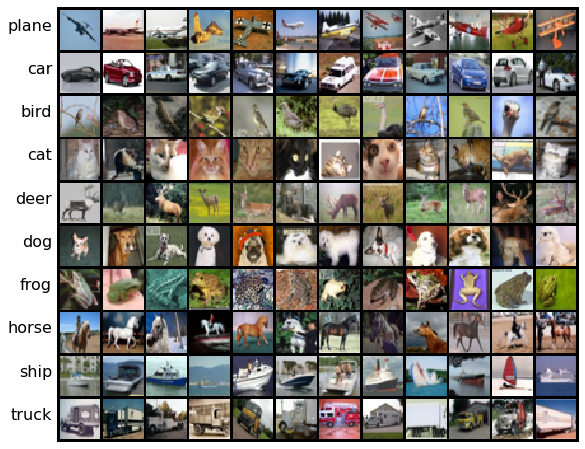

In [36]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

path = './data'
num_train = 40000
batch_size = 64

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we have hardcoded the mean and std.
# For training, we can apply random shift by up to 4 pixels and random
# horizontal flipping, which are commonly used data augmentation methods for
# small image datasets like CIFAR-10.
# Note that data augmentation is effective only when training multiple epochs.
# So, by default, we apply basic preprocessing for training as val/test, and
# apply data augmentation when training multiple epochs.
train_transform_list = [
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
]
train_transform = transforms.Compose(train_transform_list)
val_transform_list = [
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
]
val_transform = transforms.Compose(val_transform_list)

# We set up a Dataset object for each split (train/val/test); Datasets
# load training examples one at a time, so we wrap each Dataset in
# a DataLoader which iterates through the Dataset and forms minibatches.
# We divide the CIFAR-10 training set into train and val splits.
train_dataset = datasets.CIFAR10(path, train=True, download=True,
                                 transform=val_transform)
train_dataset.data = train_dataset.data[:num_train]
train_dataset.targets = train_dataset.targets[:num_train]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print('number of train data:', len(train_dataset))
print('number of iterations per epoch:', len(train_loader))

val_dataset = datasets.CIFAR10(path, train=True, download=False,
                               transform=val_transform)
val_dataset.data = val_dataset.data[num_train:]
val_dataset.targets = val_dataset.targets[num_train:]
val_loader = DataLoader(val_dataset, batch_size=batch_size)
print('number of val data:', len(val_dataset))

test_dataset = datasets.CIFAR10(path, train=False, download=False, 
                                transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
print('number of test data:', len(test_dataset))

# visualize CIFAR-10
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 12
samples = []

reset_seed(0)
for y, cls in enumerate(classes):
    plt.text(-4, 34 * y + 18, cls, ha='right')
    inds = (torch.tensor(train_dataset.targets) == y).nonzero().view(-1)
    ind = inds[torch.randperm(inds.shape[0])][:samples_per_class]
    samples.append(torch.tensor(train_dataset.data[ind]).permute(0, 3, 1, 2))
samples = torch.cat(samples, dim=0)
img = torchvision.utils.make_grid(samples, nrow=samples_per_class)
plt.imshow(img.permute(1,2,0))
plt.axis("off")
plt.show()

# Part 1. Barebones PyTorch

PyTorch ships with high-level APIs to help us define model architectures conveniently, which we will cover in Part 1 of this tutorial.
In this section, we will start with the barebone PyTorch elements to understand the autograd engine better.
After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple fully-connected ReLU network with two hidden layers. 
This implementation computes the forward pass using operations on PyTorch tensors, and uses PyTorch autograd to compute gradients.
It is important that you understand every line, because you will write a harder version after the example.

When we create a PyTorch tensor with `requires_grad=True`, then operations involving that tensor will not just compute values;
they will also build up a computational graph in the background, allowing us to easily backpropagate through the graph to compute gradients of some tensors with respect to a downstream loss.
Concretely, if `x` is a tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another tensor holding the gradient of `x` with respect to the scalar loss at the end.

## Barebones PyTorch: Two-Layer Network

Here we define a function `two_layer_fc` which performs the forward pass of a two-layer fully-connected ReLU network on a batch of image data. After defining the forward pass we check that it doesn't crash and that it produces outputs of the right shape by passing zeros through the network.

You don't have to write any code here, but it's important that you read and understand the implementation.

In [37]:
def two_layer_fc(x, params, hyperparams=None):
    """
    A fully-connected neural networks with the following architecture:

     linear - relu - linear

    Note that this function only defines the forward pass; 
    PyTorch will take care of the backward pass for us.

    The input to the network is a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer has H units,
    and the output layer produces scores for C classes.

    Inputs:
    - x: Tensor of shape (N, d1, ..., dM) giving a minibatch of input data.
    - params: List of tensors [w1, w2] giving weights for the network;
      w1 has shape (H, D) and w2 has shape (C, H).
    - hyperparams: A dictionary of hyperparameters for the network;
      should be None for this network

    Returns:
    - scores: Tensor of shape (N, C) giving classification scores for
    the input data x.
    """
    # flatten the image to the shape of [batch_size, C*H*W]
    x = x.flatten(1)

    w1, b1, w2, b2 = params

    # forward pass: compute predicted y using operations on tensors. Since w1
    # and w2 have requires_grad=True, operations involving these tensors will
    # cause PyTorch to build a computational graph, allowing automatic 
    # computation of gradients. Since we are no longer implementing the 
    # backward pass by hand, we don't need to keep references to intermediate
    # values.
    x = F.relu(F.linear(x, w1, b1))
    x = F.linear(x, w2, b2)
    return x


def two_layer_fc_test():
    # minibatch size 64, image size [3, 16, 16]
    x = torch.zeros(64, 3, 16, 16)
    hidden_size = 42
    w1 = torch.zeros(hidden_size, 3*16*16)
    b1 = torch.zeros(hidden_size)
    w2 = torch.zeros(10, hidden_size)
    b2 = torch.zeros(10)
    params = [w1, b1, w2, b2]
    scores = two_layer_fc(x, params)

    print('Output size:', tuple(scores.size()))

two_layer_fc_test()

Output size: (64, 10)


## Barebones PyTorch: Three-Layer ConvNet

**Implement** the function `three_layer_convnet`, which performs the forward pass of a three-layer convolutional network.
Like above, we can immediately test our implementation by passing zeros through the network.
The network should have the following architecture:

1. Conv layer (with bias) with `channel_1` filters, each with shape `[kernel_size_1, kernel_size_1]`, and zero-padding of `pad_size_1`
2. ReLU nonlinearity
3. Conv layer (with bias) with `channel_2` filters, each with shape `[kernel_size_2, kernel_size_2]`, and zero-padding of `pad_size_2`
4. ReLU nonlinearity
5. Fully-connected layer (with bias) to compute scores

Note that we have **no softmax activation** here after our fully-connected layer:
this is because PyTorch's cross-entropy loss performs a softmax activation for you, and by bundling that step in makes computation more efficient.

**Hint**: For convolution, take a look at the documentation for [`torch.nn.functional.conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html);
pay attention to the shapes of convolutional filters.
You can use `print(tensor.shape)` for debugging the shapes after each intemidiate layer.

After running the cell below, you should see the output size of `(64, 10)`.

In [38]:
from pytorch_autograd_and_nn import three_layer_convnet

def three_layer_convnet_test():
    # minibatch size 64, image size [3, 32, 32]
    x = torch.zeros(64, 3, 32, 32)

    # conv: [out_channel, in_channel, kernel_H, kernel_W]
    conv_w1 = torch.zeros(6, 3, 5, 5)
    conv_b1 = torch.zeros(6)  # out_channel
    pad_size_1 = 2
    # conv: [out_channel, in_channel, kernel_H, kernel_W]
    conv_w2 = torch.zeros(9, 6, 3, 3)
    conv_b2 = torch.zeros(9)  # out_channel
    pad_size_2 = 1

    # you must calculate the shape of the tensor after conv / before fc layer
    fc_w = torch.zeros(10, 9*32*32)
    fc_b = torch.zeros(10)

    params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
    hyperparams = {'padding': [pad_size_1, pad_size_2]}
    scores = three_layer_convnet(x, params, hyperparams)
    print('Output size:', tuple(scores.size()))

three_layer_convnet_test()

Output size: (64, 10)


## Barebones PyTorch: Kaiming Initialization
In this part, we are going to use [Kaiming initialization](https://arxiv.org/abs/1502.01852), which you already implemented in the previous assignment.

Fortunately, PyTorch provides a pre-implemented function, so we will use this:
[`torch.nn.init.kaiming_normal_`](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_)

By default, `gain=2`, because this function assumes that ReLU activation follows.
This is true in the linear and convolutional layers in the models you are going to implement, except for the last fully-connected layer:
in principle, we should give `gain=1` because ReLU is not applied there.
However, as stated in the [original paper](https://arxiv.org/abs/1502.01852), since the factor `1/2` does not matter if it just exists on one layer, we are going to keep using `gain=2` for simplicity.

For more details on initialization methods provided by PyTorch, see the documentation for [`torch.nn.init`](https://pytorch.org/docs/stable/nn.init.html).

In [39]:
reset_seed(0)

# create a weight of shape [3, 5]
print(nn.init.kaiming_normal_(torch.empty(3, 5)))
print(nn.init.zeros_(torch.empty(3, 5)))

tensor([[ 0.9746, -0.1856, -1.3780,  0.3595, -0.6859],
        [-0.8845,  0.2551,  0.5300, -0.4549, -0.2551],
        [-0.3773,  0.1151, -0.5418,  0.6961, -0.6775]])
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


## Barebones PyTorch: Validation
When training the model, we will use the following function to check the accuracy of our model on datasets.

When checking accuracy, we don't need to compute any gradients;
as a result, we don't need PyTorch to build a computational graph for us when we compute scores.
To prevent a graph from being built, we scope our computation under a `torch.no_grad()` context manager.

In [40]:
def validate_part1(loader, model_fn, params, hyperparams):
    """
    Vadlidate a model with barebones PyTorch.

    Inputs:
    - loader: DataLoader for the data split we want to validate
    - model_fn: A function that performs the forward pass of the model,
        with the signature scores = model_fn(x, params)
    - params: List of tensors giving parameters of the model.
    - hyperparams: Dictionary of hyperparameters for the network.

    Returns:
    - acc: Python scalar giving the model accuracy on the given data loader
    - loss_: Python scalar giving the loss on the given data loader
    - elapsed: Python scalar giving the elapsed time for validation
    """
    loss_, correct, num_data = 0, 0, 0

    with torch.no_grad():
        end = time.time()
        for iter, (x, y) in enumerate(loader):
            # move the data to the proper device (GPU or CPU)
            x = x.to(dtype=torch.float, device=device)
            y = y.to(dtype=torch.long, device=device)

            # forward pass: compute scores and loss
            scores = model_fn(x, params, hyperparams)
            loss = F.cross_entropy(scores, y)
            loss_ += loss.item() * x.shape[0]

            # check accuracy
            _, preds = scores.max(dim=1)
            correct += (preds == y).sum().item()
            num_data += x.shape[0]

    acc = correct / num_data * 100.
    loss_ /= num_data
    elapsed = time.time() - end

    return acc, loss_, elapsed

## BareBones PyTorch: Training Loop
We can now set up a basic training loop to train our network.
We will train the model using stochastic gradient descent without momentum.
We will use [`torch.nn.functional.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html) to compute the loss.

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, w2]` in our example), and learning rate.

In [41]:
def train_part1(model_fn, params, hyperparams, lr):
    """
    Train a model with barebones PyTorch.

    Inputs:
    - model_fn: Python function that performs the forward pass of the model.
        It should have the signature scores = model_fn(x, params) where x is a
        tensor of image data, params is a list of tensors giving
        model weights, and scores is a tensor of shape (N, C) giving
        scores for the elements in x.
    - params: List of tensors giving the weights and biases for the network.
    - hyperparams: A dictionary of hyperparameters for the network.
    - lr: Python scalar giving the learning rate to use for SGD.

    Returns: Dictionary of train_acc, train_loss, val_acc, val_loss, val_iter
    """
    train_acc, train_loss, val_acc, val_loss, val_iter = [], [], [], [], []

    num_iters = len(train_loader)
    time_fmt = 'Iter {:3d}/{:3d} Time {:7.3f}'
    train_fmt = ' [Train] Loss {:6.4f} Acc {:6.2f}'
    val_fmt = ' [Val] Loss {:6.4f} Acc {:6.2f}'

    end = time.time()
    for i, (x, y) in enumerate(train_loader):
        # move the data to the proper device (GPU or CPU)
        x = x.to(dtype=torch.float, device=device)
        y = y.to(dtype=torch.long, device=device)

        # forward pass: compute scores and loss
        scores = model_fn(x, params, hyperparams)
        loss = F.cross_entropy(scores, y)

        # backward pass: PyTorch figures out which tensors in the computational
        # graph has requires_grad=True and uses backpropagation to compute the
        # gradient of the loss with respect to these tensors, and stores the
        # gradients in the .grad attribute of each tensor.
        loss.backward()

        # update parameters using SGD. We don't want to backpropagate through
        # the parameter updates, so we scope the updates under torch.no_grad()
        # context manager to prevent a computational graph from being built.
        with torch.no_grad():
            for w in params:
                if w.requires_grad:
                    w -= lr * w.grad

                    # manually zero-out the gradients after backward pass
                    w.grad.zero_()

            # check accuracy
            _, preds = scores.max(dim=1)
            acc = (preds == y).to(torch.float).mean().item()*100.

        # logging
        train_loss.append(loss.item())
        train_acc.append(acc)

        if i % 100 == 0 or i == len(train_loader)-1:
            # validation
            acc, loss, _ = validate_part1(val_loader, model_fn,
                                          params, hyperparams)

            # logging
            val_loss.append(loss)
            val_acc.append(acc)
            val_iter.append(i)

            # display the progress
            prog = time_fmt.format(i, num_iters, time.time() - end)
            prog += train_fmt.format(train_loss[-1], train_acc[-1])
            prog += val_fmt.format(val_loss[-1], val_acc[-1])
            print(prog)

    return {'train_acc': train_acc, 'train_loss': train_loss,
            'val_acc': val_acc, 'val_loss': val_loss, 'val_iter': val_iter}

## BareBones PyTorch: Train a Two-Layer Network
Now we are ready to run the training loop. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`. 

Each minibatch has 64 examples, so the tensor shape is `[64, 3, 32, 32]`. 

After flattening, the shape of the input `x` should be `[64, 3 * 32 * 32]`.
This will be the size of the second dimension of `w1`. 
The first dimension of `w1` is the hidden layer size, which will also be the second dimension of `w2`. 

Finally, the output of the network is a 10-dimensional vector that represents the probability distribution over 10 classes. 

You don't need to tune any hyperparameters or implement anything, but you should see a validation accuracy above **40%** after one epoch of training.

In [42]:
reset_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

hidden_size = 100
lr = 1e-2

# for brevity
learnable = {'dtype': torch.float, 'device': device, 'requires_grad': True}

w1 = nn.init.kaiming_normal_(torch.empty(hidden_size, C*H*W, **learnable))
b1 = nn.init.zeros_(torch.empty(hidden_size, **learnable))
w2 = nn.init.kaiming_normal_(torch.empty(num_classes, hidden_size, **learnable))
b2 = nn.init.zeros_(torch.empty(num_classes, **learnable))

params = [w1, b1, w2, b2]
hyperparams = None

_ = train_part1(two_layer_fc, params, hyperparams, lr)

Iter   0/625 Time   2.130 [Train] Loss 3.2652 Acc  10.94 [Val] Loss 3.1476 Acc  11.06
Iter 100/625 Time   5.749 [Train] Loss 2.1484 Acc  34.38 [Val] Loss 1.9713 Acc  34.02
Iter 200/625 Time   9.300 [Train] Loss 1.7895 Acc  42.19 [Val] Loss 1.8628 Acc  36.56
Iter 300/625 Time  12.816 [Train] Loss 1.8633 Acc  43.75 [Val] Loss 1.8254 Acc  38.31
Iter 400/625 Time  16.568 [Train] Loss 1.7805 Acc  43.75 [Val] Loss 1.7564 Acc  39.98
Iter 500/625 Time  21.025 [Train] Loss 1.7502 Acc  42.19 [Val] Loss 1.6998 Acc  41.52
Iter 600/625 Time  24.507 [Train] Loss 1.6258 Acc  43.75 [Val] Loss 1.6925 Acc  41.25
Iter 624/625 Time  26.900 [Train] Loss 1.5277 Acc  53.12 [Val] Loss 1.6933 Acc  41.74


## BareBones PyTorch: Training a ConvNet

**Implement** `initialize_three_layer_conv_part1` function and run the following cell. 

You don't need to tune any hyperparameters, but you should see a validation accuracy above **47%** after one epoch of training.

In [43]:
from pytorch_autograd_and_nn import initialize_three_layer_conv_part1

reset_seed(0)
lr = 1e-2

params, hyperparams = initialize_three_layer_conv_part1(device=device)
hist_part1 = train_part1(three_layer_convnet, params, hyperparams, lr)

Iter   0/625 Time   2.222 [Train] Loss 2.9512 Acc  15.62 [Val] Loss 3.3255 Acc  11.50
Iter 100/625 Time   5.917 [Train] Loss 1.7438 Acc  43.75 [Val] Loss 1.8432 Acc  34.58
Iter 200/625 Time   9.663 [Train] Loss 1.8136 Acc  31.25 [Val] Loss 1.6938 Acc  40.92
Iter 300/625 Time  13.363 [Train] Loss 1.5894 Acc  45.31 [Val] Loss 1.6364 Acc  43.21
Iter 400/625 Time  17.044 [Train] Loss 1.5053 Acc  51.56 [Val] Loss 1.5472 Acc  45.54
Iter 500/625 Time  20.793 [Train] Loss 1.4542 Acc  51.56 [Val] Loss 1.4928 Acc  47.65
Iter 600/625 Time  24.494 [Train] Loss 1.5425 Acc  48.44 [Val] Loss 1.4589 Acc  48.54
Iter 624/625 Time  26.950 [Train] Loss 1.4167 Acc  50.00 [Val] Loss 1.4393 Acc  49.41


# Part 2. PyTorch Module API

Barebone PyTorch requires that we track all the tensors for learnable parameters by hand.
This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you.
In Part 1, we implemented SGD ourselves.
PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam.
It even supports approximate second-order methods like L-BFGS!
You can refer to the documentation for [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`.

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the documentation for [`torch.nn`](https://pytorch.org/docs/stable/nn.html) to learn more about the dozens of builtin layers. **Note that you should call `super().__init__()` first.**

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the *transformed* tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`.

After you define your `nn.Module` subclass, you can instantiate it as an object and call it just like the forward function in part 1.

## Module API: Two-Layer Network
Here is a concrete example of a two-layer fully connected network.
We use `nn.init.kaiming_normal_` to initialize weights using Kaiming initialization, and `nn.init.zeros_` to initialize biases.

For sanity check, we pass a batch of zero images and check the output size and loss, and count the number of learnable parameters.
The output size should be `(64, 10)`, the initial loss should be around `2.3`, and the number of learnable parameters should be `308310`.

In [44]:
from common import count_num_params

class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
  
    def forward(self, x):
        # forward defines connectivity
        x = x.flatten(1)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    reset_seed(0)

    # in_shape: C, H, W
    in_shape = (3, 32, 32)
    input_size = torch.prod(torch.tensor(in_shape))
    num_classes = 10

    # hidden_size
    hidden_size = 100

    # minibatch size 64, image size (3, 32, 32)
    x = torch.zeros(64, *in_shape)
    y = torch.randint(num_classes, size=(64,))

    model = TwoLayerFC(input_size, hidden_size, num_classes)
    with torch.no_grad():
        scores = model(x)
        loss = F.cross_entropy(scores, y)

    # printing nn.Module shows the architecture of the module.
    print(model)

    print('Output size:', tuple(scores.size()))
    print('Init loss:', loss.item())
    print('Number of learnable parameters:', count_num_params(model))

test_TwoLayerFC()

TwoLayerFC(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)
Output size: (64, 10)
Init loss: 2.3025851249694824
Number of learnable parameters: 308310


## Module API: Three-Layer ConvNet
**Implement** `ThreeLayerConvNet`.
The network architecture should be the same as Part 1:

1. Conv layer (with bias) with `channel_1` filters, each with shape `[kernel_size_1, kernel_size_1]`, and zero-padding of `pad_size_1`
2. ReLU nonlinearity
3. Conv layer (with bias) with `channel_2` filters, each with shape `[kernel_size_2, kernel_size_2]`, and zero-padding of `pad_size_2`
4. ReLU nonlinearity
5. Fully-connected layer (with bias) to compute scores

For sanity check, we pass a batch of zero images and check the output size and loss, and count the number of learnable parameters.
The output size should be `(64, 10)`, the initial loss should be around `2.3`, and the number of learnable parameters should be `83714`.

In [45]:
from common import count_num_params
from pytorch_autograd_and_nn import ThreeLayerConvNet

def test_ThreeLayerConvNet():
    reset_seed(0)

    # in_shape: C, H, W
    in_shape = (3, 32, 32)
    num_classes = 10

    # conv_params: [(channel_size, kernel_size, pad_size)] * num_layers
    conv_params = [(12, 5, 2), (8, 3, 1)]

    # minibatch size 64, image size (3, 32, 32)
    x = torch.zeros(64, *in_shape)
    y = torch.randint(num_classes, size=(64,))

    model = ThreeLayerConvNet(in_shape, conv_params, num_classes)
    with torch.no_grad():
        scores = model(x)
        loss = F.cross_entropy(scores, y)

    # printing nn.Module shows the architecture of the module.
    print(model)

    print('Output size:', tuple(scores.size()))
    print('Init loss:', loss.item())
    print('Number of learnable parameters:', count_num_params(model))

test_ThreeLayerConvNet()

ThreeLayerConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(12, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=8192, out_features=10, bias=True)
)
Output size: (64, 10)
Init loss: 2.3025851249694824
Number of learnable parameters: 83714


## Module API: Validation
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in Part 1, as you don't manually pass in the parameters anymore.

In [46]:
def validate(loader, model):
    """
    Vadlidate a model with the PyTorch Module API.

    Inputs:
    - loader: DataLoader for the data split we want to validate
    - model: PyTorch module that performs the forward pass of the model,
        with the signature scores = model(x)

    Returns:
    - acc: Python scalar giving the model accuracy on the given data loader
    - loss_: Python scalar giving the loss on the given data loader
    - elapsed: Python scalar giving the elapsed time for validation
    """
    loss_, correct, num_data = 0, 0, 0

    # set model to evaluation mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for iter, (x, y) in enumerate(loader):
            # move the data to the proper device (GPU or CPU)
            x = x.to(dtype=torch.float, device=device)
            y = y.to(dtype=torch.long, device=device)

            # forward pass: compute scores and loss
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            loss_ += loss.item() * x.shape[0]

            # check accuracy
            _, preds = scores.max(dim=1)
            correct += (preds == y).sum().item()
            num_data += x.shape[0]

    acc = correct / num_data * 100.
    loss_ /= num_data
    elapsed = time.time() - end

    return acc, loss_, elapsed

## Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [47]:
def train(model, optimizer, epochs=1, print_every=100):
    """
    Train a model with the PyTorch Module API.

    Inputs:
    - model: PyTorch Module giving the model to train.
    - optimizer: Optimizer object we will use to train the model.
    - epochs: Python integer giving the number of epochs
    - elapsed: Python float giving the time spent for training so far
    - print_every: How frequently print a log

    Returns: Dictionary of train_acc, train_loss, val_acc, val_loss, val_iter
    """
    train_acc, train_loss, val_acc, val_loss, val_iter = [], [], [], [], []

    verbose = print_every > 0
    num_iters = len(train_loader)
    time_fmt = 'Epoch {:2d} Iter {:3d}/{:3d} Time {:7.3f}'
    train_fmt = ' [Train] Loss {:6.4f} Acc {:6.2f}'
    val_fmt = ' [Val] Loss {:6.4f} Acc {:6.2f}'

    # move the model to the proper device (GPU or CPU)
    model = model.to(device=device)

    end = time.time()
    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            # set model to training mode
            model.train()

            # move the data to the proper device (GPU or CPU)
            x = x.to(dtype=torch.float, device=device)
            y = y.to(dtype=torch.long, device=device)

            # forward pass: compute scores and loss
            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # zero-out all gradients for variables the optimizer will update.
            optimizer.zero_grad()

            # backward pass: compute gradients of the loss w.r.t. parameters.
            loss.backward()

            # update model params using gradients computed by backward pass.
            optimizer.step()

            # check accuracy
            with torch.no_grad():
                _, preds = scores.max(dim=1)
                acc = (preds == y).to(torch.float).mean().item()*100.

            # logging
            train_loss.append(loss.item())
            train_acc.append(acc)

            print_verbose = (verbose and i % print_every == 0)
            if print_verbose or i == len(train_loader)-1:
                # validation
                acc, loss, _ = validate(val_loader, model)

                # logging
                val_loss.append(loss)
                val_acc.append(acc)
                val_iter.append(i + epoch * num_iters)

                # display the progress
                prog = time_fmt.format(epoch, i, num_iters, time.time() - end)
                prog += train_fmt.format(train_loss[-1], train_acc[-1])
                prog += val_fmt.format(val_loss[-1], val_acc[-1])
                print(prog)

    return {'train_acc': train_acc, 'train_loss': train_loss,
            'val_acc': val_acc, 'val_loss': val_loss, 'val_iter': val_iter}

## Module API: Train a Two-Layer Network
Now, we are ready to run the training loop.
In contrast to part 1, we don't explicitly allocate parameter tensors anymore.
Simply pass the input size, hidden layer size, and number of classes (i.e., output size) to the constructor of `TwoLayerFC`.
You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

Again, You don't need to tune any hyperparameters or implement anything, but you should see a validation accuracy above **41%** after one epoch of training.

In [48]:
reset_seed(0)

# Input/Output dimensions
C, H, W = 3, 32, 32
num_classes = 10
hidden_size = 100

# Parameters for optimizer
lr = 1e-2
momentum = 0.5
weight_decay = 1e-4

model = TwoLayerFC(C*H*W, hidden_size, num_classes)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum,
                      weight_decay=weight_decay)

_ = train(model, optimizer)

Epoch  0 Iter   0/625 Time   2.135 [Train] Loss 3.6101 Acc   4.69 [Val] Loss 3.0662 Acc  11.46
Epoch  0 Iter 100/625 Time   5.657 [Train] Loss 1.9253 Acc  35.94 [Val] Loss 1.9675 Acc  33.85
Epoch  0 Iter 200/625 Time   9.132 [Train] Loss 2.1157 Acc  28.12 [Val] Loss 1.8368 Acc  37.04
Epoch  0 Iter 300/625 Time  12.649 [Train] Loss 1.8141 Acc  37.50 [Val] Loss 1.7687 Acc  39.95
Epoch  0 Iter 400/625 Time  16.109 [Train] Loss 1.7486 Acc  43.75 [Val] Loss 1.7265 Acc  40.18
Epoch  0 Iter 500/625 Time  19.622 [Train] Loss 1.5094 Acc  40.62 [Val] Loss 1.7304 Acc  40.60
Epoch  0 Iter 600/625 Time  23.188 [Train] Loss 1.5147 Acc  45.31 [Val] Loss 1.6611 Acc  42.27
Epoch  0 Iter 624/625 Time  25.561 [Train] Loss 1.5425 Acc  42.19 [Val] Loss 1.6610 Acc  43.26


## Module API: Train a Three-Layer ConvNet
You should now use the Module API to train a three-layer ConvNet on CIFAR-10.
This should look similar to training the two-layer network.
**Implement** the `initialize_three_layer_conv_part2` function.
You should train the model using stochastic gradient descent with momentum and L2 weight decay.

You don't need to tune any hyperparameters, but you should see a validation accuracy above **48%** after one epoch of training.

In [49]:
from pytorch_autograd_and_nn import initialize_three_layer_conv_part2

reset_seed(0)
model, optimizer = initialize_three_layer_conv_part2()
hist_part2 = train(model, optimizer)

Epoch  0 Iter   0/625 Time   2.191 [Train] Loss 3.2513 Acc   4.69 [Val] Loss 5.7981 Acc  11.64
Epoch  0 Iter 100/625 Time   5.956 [Train] Loss 1.9517 Acc  26.56 [Val] Loss 1.7723 Acc  38.09
Epoch  0 Iter 200/625 Time   9.661 [Train] Loss 1.4122 Acc  51.56 [Val] Loss 1.5910 Acc  44.39
Epoch  0 Iter 300/625 Time  13.332 [Train] Loss 1.5194 Acc  45.31 [Val] Loss 1.5200 Acc  46.02
Epoch  0 Iter 400/625 Time  17.093 [Train] Loss 1.3509 Acc  54.69 [Val] Loss 1.4832 Acc  47.77
Epoch  0 Iter 500/625 Time  20.956 [Train] Loss 1.4202 Acc  51.56 [Val] Loss 1.4289 Acc  49.84
Epoch  0 Iter 600/625 Time  24.645 [Train] Loss 1.5369 Acc  42.19 [Val] Loss 1.3961 Acc  50.01
Epoch  0 Iter 624/625 Time  27.168 [Train] Loss 1.3149 Acc  51.56 [Val] Loss 1.4611 Acc  49.10


# Part 3. PyTorch Sequential API

Part 2 introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

However, for simple models like a stack of feedforward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`.
Is there a more convenient way? 

PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one.
It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feedforward stack, but it's good enough for many use cases.

## Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.

Again, You don't need to tune any hyperparameters or implement anything, but you should see a validation accuracy above **41%** after one epoch of training.

In [50]:
from common import count_num_params

reset_seed(0)
C, H, W = 3, 32, 32
num_classes = 10

hidden_size = 100
lr = 3e-4
weight_decay = 1e-4

# To give a specific name to each module, use OrderedDict.
model = nn.Sequential(OrderedDict([
    ('flatten', nn.Flatten()),
    ('fc1', nn.Linear(C*H*W, hidden_size)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(hidden_size, num_classes)),
]))

for m in model.modules():
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)

# printing nn.Module shows the architecture of the module.
print(model)
print('Number of learnable parameters:', count_num_params(model))
print()

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

_ = train(model, optimizer)

Sequential(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)
Number of learnable parameters: 308310

Epoch  0 Iter   0/625 Time   2.136 [Train] Loss 3.6101 Acc   4.69 [Val] Loss 3.0820 Acc  11.23
Epoch  0 Iter 100/625 Time   5.669 [Train] Loss 1.8430 Acc  39.06 [Val] Loss 2.0114 Acc  34.12
Epoch  0 Iter 200/625 Time   9.189 [Train] Loss 2.2107 Acc  34.38 [Val] Loss 1.9177 Acc  36.23
Epoch  0 Iter 300/625 Time  12.716 [Train] Loss 1.7152 Acc  43.75 [Val] Loss 1.7980 Acc  39.54
Epoch  0 Iter 400/625 Time  16.238 [Train] Loss 1.8232 Acc  42.19 [Val] Loss 1.8138 Acc  39.50
Epoch  0 Iter 500/625 Time  19.780 [Train] Loss 1.7661 Acc  35.94 [Val] Loss 1.7367 Acc  41.51
Epoch  0 Iter 600/625 Time  23.336 [Train] Loss 1.7670 Acc  35.94 [Val] Loss 1.7368 Acc  41.20
Epoch  0 Iter 624/625 Time  25.749 [Train] Loss 1.7630 Acc  35.94 [Val] Loss 1.7247 Acc  43.0

## Sequential API: Three-Layer ConvNet
**Implement** `initialize_three_layer_conv_part3` using `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in Part 2, but `Flatten` should be explicitly there as a layer:

1. Conv layer (with bias) with `channel_1` filters, each with shape `[kernel_size_1, kernel_size_1]`, and zero-padding of `pad_size_1`
2. ReLU nonlinearity
3. Conv layer (with bias) with `channel_2` filters, each with shape `[kernel_size_2, kernel_size_2]`, and zero-padding of `pad_size_2`
4. ReLU nonlinearity
5. Flatten
6. Fully-connected layer (with bias) to compute scores

You should train the model using Adam with L2 weight decay.

For sanity check, we count the number of learnable parameters, which should be `83714`.

You don't need to tune any hyperparameters, but you should see a validation accuracy above **48%** after one epoch of training.

In [51]:
from common import count_num_params
from pytorch_autograd_and_nn import initialize_three_layer_conv_part3

reset_seed(0)
model, optimizer = initialize_three_layer_conv_part3()

# printing nn.Module shows the architecture of the module.
print(model)
print('Number of learnable parameters:', count_num_params(model))
print()

hist_part3 = train(model, optimizer)

Sequential(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (conv2): Conv2d(12, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=8192, out_features=10, bias=True)
)
Number of learnable parameters: 83714

Epoch  0 Iter   0/625 Time   2.191 [Train] Loss 3.2513 Acc   4.69 [Val] Loss 4.9888 Acc  11.64
Epoch  0 Iter 100/625 Time   5.966 [Train] Loss 1.7696 Acc  34.38 [Val] Loss 1.6921 Acc  40.30
Epoch  0 Iter 200/625 Time   9.655 [Train] Loss 1.3049 Acc  60.94 [Val] Loss 1.5954 Acc  43.56
Epoch  0 Iter 300/625 Time  13.405 [Train] Loss 1.5281 Acc  48.44 [Val] Loss 1.4807 Acc  47.63
Epoch  0 Iter 400/625 Time  17.141 [Train] Loss 1.4032 Acc  50.00 [Val] Loss 1.4719 Acc  47.81
Epoch  0 Iter 500/625 Time  20.866 [Train] Loss 1.4792 Acc  54.69 [Val] Loss 1.4107 Acc  50.21
Epoch  0 Iter 600/625 Time  25.700 [Train] Loss 1.4770 Acc  48.44 [Val] Loss 1.378

# Part 4. ResNet for CIFAR-10

In this section, you are going to implement [ResNet](https://arxiv.org/abs/1512.03385), one of the state-of-the-art CNN architecture.
Specifically, you are going to implement a variation of ResNet called [PreResNet](https://arxiv.org/abs/1603.05027), which locates activation before each convolutional layer (so called pre-activation).
You are going to first implement a plain building block, residual block, and then bottleneck block for very deep networks.
Finally, you will implement your own ResNet using those blocks.

Throughout this part, we will follow the PyTorch default weight initialization for conciseness.

## Plain Block

First, let's implement a plain block without residual connection.
PreResNet has a different order of layers from the previously implemented ones;
`BatchNorm` and `ReLU` precedes `Conv`.
The name of PreResNet comes form this pre-activation architecture.
Here, for downsampling, we don't introduce `MaxPool` layers explicitly, but use stride 2 in the first `Conv` layer in the block.
Also, `Conv` is always followed by `BatchNorm`, such that the bias has no effect;
thus, we set `bias=False` for `Conv`.

Concretely, a plain block accepts a batch of feature map of shape $N \times C_{\text{in}} \times H_{\text{in}} \times W_{\text{in}}$ and produces a feature map of shape $N \times C_{\text{out}} \times H_{\text{out}} \times W_{\text{out}}$.
If the block performs downsampling, then $W_{\text{out}}=W_{\text{in}}/2$ and $H_{\text{out}}=H_{\text{in}}/2$;
otherwise, $H_{\text{out}}=H_{\text{in}}$ and $W_{\text{out}}=W_{\text{in}}$.
The plain block consists of the following six layers in order:

1. Spatial Batch normalization with `Cin` channels
2. ReLU
3. Conv layer (without bias) with `Cout` 3x3 filters, zero-padding of 1, and stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization with `Cout` channels
5. ReLU
6. Conv layer (without bias) with `Cout` 3x3 filters and zero-padding of 1

**Implement** the `PlainBlock.__init__` function and run the following cell. You should see a message indicating that your implementation is correct.


In [52]:
from common import count_num_layers, count_num_params
from pytorch_autograd_and_nn import PlainBlock

data = torch.zeros(2, 3, 5, 6)

# Case 1: downsample=False
model = PlainBlock(3, 10)
template = 'Case 1: The output dimension of PlainBlock is'
if list(model(data).shape) == [2, 10, 5, 6]:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected:',
          [2, 10, 5, 6], 'got:', list(model(data).shape))

num_layers = count_num_layers(model)
template = 'Case 1: The number of layers in PlainBlock is'
if num_layers == 2:
    print(template, '*correct*')
else:
    print(template, '*incorrect*', 'expected: 2 got:', num_layers)

num_params = count_num_params(model)
template = 'Case 1: The number of params in PlainBlock is'
if num_params == 1196:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 1196 got:', num_params)

# Case 2: downsample=True
model = PlainBlock(3, 10, downsample=True)
template = 'Case 2: The output dimension of PlainBlock is'
if list(model(data).shape) == [2, 10, 3, 3]:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected:',
          [2, 10, 3, 3], 'got:', list(model(data).shape))

num_layers = count_num_layers(model)
template = 'Case 2: The number of layers in PlainBlock is'
if num_layers == 2:
    print(template, '*correct*')
else:
    print(template, '*incorrect*', 'expected: 2 got:', num_layers)

num_params = count_num_params(model)
template = 'Case 2: The number of params in PlainBlock is'
if num_params == 1196:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 1196 got:', num_params)

Case 1: The output dimension of PlainBlock is *correct*
Case 1: The number of layers in PlainBlock is *correct*
Case 1: The number of params in PlainBlock is *correct*
Case 2: The output dimension of PlainBlock is *correct*
Case 2: The number of layers in PlainBlock is *correct*
Case 2: The number of params in PlainBlock is *correct*


## Residual Block

Next, let's implement a residual block.
A residual block adds a residual connection to a plain block. Let $\mathcal{F}$ be a plain block; then the residual version  $\mathcal{R}$ of the plain block $\mathcal{F}$ computes:

$\mathcal{R}(x) = \mathcal{F}(x) + x$

However, this implementation will only work if the output from the plain block $\mathcal{F}(x)$ has the same shape as the input $x$. Based on the plain block that we implemented above, there are two cases where the output of the plain block can have a different shape than the input:

1. The number of output channels $C_{\text{out}}$ is different from the number of input channels $C_{\text{in}}$
2. The plain block $\mathcal{F}$ performs spatial downsampling

To deal with these cases, we need generalize our definition of the residual block and add a *shortcut connection* $\mathcal{G}$:

$\mathcal{R}(x) = \mathcal{F}(x) + \mathcal{G}(x)$

There are three cases for the shortcut connection $\mathcal{G}$:

1. If $C_{\text{in}}=C_{\text{out}}$ and $\mathcal{F}$ does not perform downsampling, then $\mathcal{F}(x)$ will have the same shape as $x$, so $\mathcal{G}$ is the identity function: $\mathcal{G}(x) = x$
2. If $C_{\text{in}} \neq C_{\text{out}}$ and $\mathcal{F}$ does not downsample, then $\mathcal{G}$ is a 1x1 convolution (without bias) with $C_{\text{out}}$ filters and stride 1.
3. If $\mathcal{F}$ downsamples, then $\mathcal{G}$ is a 1x1 convolution (without bias) with $C_{\text{out}}$ filters and stride 2.

**Implement** the `ResidualBlock.__init__` function and run the following cell. You should see a message indicating that your implementation is correct.

In [53]:
from common import count_num_layers, count_num_params
from pytorch_autograd_and_nn import ResidualBlock

data = torch.zeros(2, 3, 5, 6)

# Case 1: Cin == Cout, downsample=False
model = ResidualBlock(3, 3)
template = 'Case 1: The output dimension of ResidualBlock is'
if list(model(data).shape) == [2, 3, 5, 6]:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected:',
          [2, 3, 5, 6], 'got:', list(model(data).shape))

num_layers = count_num_layers(model)
template = 'Case 1: The number of layers in ResidualBlock is'
if num_layers == 2:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 2 got:', num_layers)

num_params = count_num_params(model)
template = 'Case 1: The number of params in ResidualBlock is'
if num_params == 174:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 174 got:', num_params)

# Case 2: Cin != Cout, downsample=False
model = ResidualBlock(3, 10)
template = 'Case 2: The output dimension of ResidualBlock is'
if list(model(data).shape) == [2, 10, 5, 6]:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected:',
          [2, 10, 5, 6], 'got:', list(model(data).shape))

num_layers = count_num_layers(model)
template = 'Case 2: The number of layers in ResidualBlock is'
if num_layers == 2:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 2 got:', num_layers)

num_params = count_num_params(model)
template = 'Case 2: The number of params in ResidualBlock is'
if num_params == 1226:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 1226 got:', num_params)

# Case 3: Cin != Cout, downsample=True
model = ResidualBlock(3, 10, downsample=True)
template = 'Case 3: The output dimension of ResidualBlock is'
if list(model(data).shape) == [2, 10, 3, 3]:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected:',
          [2, 10, 3, 3], 'got:', list(model(data).shape))

num_params = count_num_params(model)
template = 'Case 3: The number of params in ResidualBlock is'
if num_params == 1226:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 1226 got:', num_params)

num_layers = count_num_layers(model)
template = 'Case 3: The number of layers in ResidualBlock is'
if num_layers == 2:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 2 got:', num_layers)

Case 1: The output dimension of ResidualBlock is *correct*
Case 1: The number of layers in ResidualBlock is *correct*
Case 1: The number of params in ResidualBlock is *correct*
Case 2: The output dimension of ResidualBlock is *correct*
Case 2: The number of layers in ResidualBlock is *correct*
Case 2: The number of params in ResidualBlock is *correct*
Case 3: The output dimension of ResidualBlock is *correct*
Case 3: The number of params in ResidualBlock is *correct*
Case 3: The number of layers in ResidualBlock is *correct*


## Residual Stage

So far, you implemented micro layers, which consists of several convolutional layers.
To efficiently build a deep neural network, we define a macro layer by repeating the micro layers.

For your convenience, we provide the implementation in `pytorch_autograd_and_nn.py`; just run the code below.

```
class ResNetStage(nn.Module):
    def __init__(self, Cin, Cout, num_blocks, downsample=True,
                 block=ResidualBlock):
        super().__init__()
        blocks = [block(Cin, Cout, downsample)]
        for _ in range(num_blocks - 1):
            blocks.append(block(Cout * block.expansion, Cout))
        self.net = nn.Sequential(*blocks)

    def forward(self, x):
        return self.net(x)
```




In [54]:
from common import count_num_layers, count_num_params
from pytorch_autograd_and_nn import ResNetStage

# Case 1: PlainBlock stage
model = ResNetStage(3, 4, 2, block=PlainBlock)

num_params = count_num_params(model)
template = 'Case 1: The number of params in PlainBlock stage is'
if num_params == 570:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 570 got:', num_params)

num_layers = count_num_layers(model)
template = 'Case 1: The number of layers in PlainBlock stage is'
if num_layers == 4:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 4 got:', num_layers)
print(model)
print()

# Case 2: ResidualBlock stage
model = ResNetStage(3, 4, 2, block=ResidualBlock)

num_params = count_num_params(model)
template = 'Case 2: The number of params in ResidualBlock stage is'
if num_params == 582:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 582 got:', num_params)

num_layers = count_num_layers(model)
template = 'Case 2: The number of layers in ResidualBlock stage is'
if num_layers == 4:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 4 got:', num_layers)
print(model)

Case 1: The number of params in PlainBlock stage is *correct*
Case 1: The number of layers in PlainBlock stage is *correct*
ResNetStage(
  (net): Sequential(
    (0): PlainBlock(
      (net): Sequential(
        (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (1): PlainBlock(
      (net): Sequential(
        (0): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(4

## Residual Stem

A *stem* layer is required at the beginning of the network, which increases the number of channels while keeping the other dimensions.
For high resolution images, e.g., 224x224, we usually downsample by 7x7 conv with zero-padding of 3 and stride of 2 followed by 2x2 max-pooling; however, we do not downsample at stem for low resolution images, e.g., 32x32.

For your convenience, we provide the implementation in `pytorch_autograd_and_nn.py`; just run the code below.

```
class ResNetStem(nn.Module):
    def __init__(self, Cin=3, Cout=16):
        super().__init__()
        self.net = nn.Conv2d(Cin, Cout, kernel_size=3, stride=1, padding=1,
                             bias=False)

    def forward(self, x):
        return self.net(x)
```

In [55]:
from common import count_num_params
from pytorch_autograd_and_nn import ResNetStem

data = torch.zeros(2, 3, 5, 6)
model = ResNetStem(3, 10)
template = 'The output dimension of ResNetStem is'
if list(model(data).shape) == [2, 10, 5, 6]:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected:',
          [2, 10, 5, 6], 'got:', list(model(data).shape))

num_params = count_num_params(model)
template = 'The number of params in ResNetStem is'
if num_params == 270:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 270 got:', num_params)

The output dimension of ResNetStem is *correct*
The number of params in ResNetStem is *correct*


## ResNet Class

Now, it is time to design the ResNet class using the blocks you implemented above!

For general applicability, the class will get a dictionary of the architecture specification as an input, and parse it to build a CNN.

Here we provide a couple of examples of specification;
`networks` is a collection of pre-defined network specifications, where each can be called by `get_resnet(key)`, where key is the name of the network, e.g., `get_resnet('resnet34')` will return a ResNet with 34 layers.

Each specification consists of multiple tuples which correspond to a macro block (`ResNetStage`), and the values in each tuple implies `(num_channels, num_blocks, do_downsample)`.
The number of output channels for the stem and input channels for the first stage should be the same as the number of output channels for the first stage.
The following stages take the number of output channels for the previous channels as the number of input channels.
The architecture should look like:

`stem - [block] * N - batchnorm - relu - avgpool - fc`

To avoid dependency on the size of the input, ResNet has an average pooling at the end of the convolutional part, such that the size of the input tensor to the linear layer is always `(batch_size, stage_args[-1][0])`.

You may want to add an average pooling layer (`nn.AvgPool2d`) for global average pooling, but it requires to know the size of the input.
To avoid this, you can use adaptive average pooling layer (`nn.AdaptiveAvgPool2d`), or perform global average pooling in `forward`.

**Implement** `ResNet.__init__` and `ResNet.forward` and train it on CIFAR-10.

In [75]:
from common import count_num_layers, count_num_params
from pytorch_autograd_and_nn import PlainBlock, ResidualBlock, ResNet

# example of specifications; number of channels is reduced from
# the original ResNet design for quick experiments
networks = {
    'plain34': {
        'block': PlainBlock,
        'stage_args': [
            (16, 3, False),
            (32, 4, True),
            (64, 6, True),
            (128, 3, True),
        ]
    },
    'resnet34': {
        'block': ResidualBlock,
        'stage_args': [
            (16, 3, False),
            (32, 4, True),
            (64, 6, True),
            (128, 3, True),
        ]
    },
}

def get_resnet(arch_name):
    return ResNet(**networks[arch_name])

arch_names = ['plain34', 'resnet34']
expected_num_params_list = [1323418, 1334170]
for arch_name, expected_num_params in zip(arch_names, expected_num_params_list):
    model = get_resnet(arch_name)

    num_layers = count_num_layers(model)
    template = 'The number of layers in ' + arch_name + ' is'
    if num_layers == 34:
        print(template, '*correct*')
    else:
        print(template, '*incorrect*; expected: 34 got:', num_layers)

    num_params = count_num_params(model)
    template = 'The number of params in ' + arch_name + ' is'
    if num_params == expected_num_params:
        print(template, '*correct*')
    else:
        print(template, '*incorrect*; expected:', expected_num_params,
              'got:', num_params)

The number of layers in plain34 is *correct*
The number of params in plain34 is *correct*
The number of layers in resnet34 is *correct*
The number of params in resnet34 is *correct*


## Train Your Model!

Now let's train a few epochs of plain and residual networks with 34 layers on CIFAR-10.
As we will train multiple epochs here, we can apply data augmentations to improve the performance.
You will see that deep plain (non-residual) networks don't converge well; the val/test accuracy would be around **67~72%** for plain networks, and **80~85%** for residual networks.
You might get more consistent and better result by training longer, but please use the default setting in your submission.

**Caution: This takes a long time! (~10 mins)**

**Disclaimer: The performance of PreResNet-34 you will see here would be lower than the best performance this model can achieve, because the convergence requires longer training.**

In [57]:
# apply data augmentation to train_dataset
train_dataset.transform = train_transform

arch_names = ['plain34', 'resnet34']
hist = {}
for arch_name in arch_names:
    reset_seed(0)
    print(arch_name)

    model = get_resnet(arch_name)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    hist[arch_name] = train(model, optimizer, epochs=10, print_every=0)

    test_acc, test_loss, _ = validate(test_loader, model)
    print('[Test] Loss {:6.4f} Acc {:6.2f}\n'.format(test_loss, test_acc))
    hist[arch_name].update({'test_acc': test_acc, 'test_loss': test_loss})

# remove data augmentation from train_dataset
train_dataset.transform = val_transform

plain34
Epoch  0 Iter 624/625 Time  31.689 [Train] Loss 1.7948 Acc  39.06 [Val] Loss 1.8483 Acc  30.62
Epoch  1 Iter 624/625 Time  63.161 [Train] Loss 1.5234 Acc  31.25 [Val] Loss 1.6082 Acc  39.05
Epoch  2 Iter 624/625 Time  94.247 [Train] Loss 1.2523 Acc  51.56 [Val] Loss 1.7795 Acc  39.96
Epoch  3 Iter 624/625 Time 125.477 [Train] Loss 1.4069 Acc  54.69 [Val] Loss 1.3483 Acc  51.55
Epoch  4 Iter 624/625 Time 157.822 [Train] Loss 1.1987 Acc  53.12 [Val] Loss 1.2210 Acc  57.19
Epoch  5 Iter 624/625 Time 189.356 [Train] Loss 1.2350 Acc  60.94 [Val] Loss 1.2088 Acc  59.72
Epoch  6 Iter 624/625 Time 221.269 [Train] Loss 0.9853 Acc  67.19 [Val] Loss 1.1725 Acc  58.80
Epoch  7 Iter 624/625 Time 253.016 [Train] Loss 1.0832 Acc  57.81 [Val] Loss 1.0190 Acc  63.84
Epoch  8 Iter 624/625 Time 285.263 [Train] Loss 1.2501 Acc  54.69 [Val] Loss 0.9008 Acc  68.44
Epoch  9 Iter 624/625 Time 317.141 [Train] Loss 1.0486 Acc  62.50 [Val] Loss 0.8863 Acc  69.93
[Test] Loss 0.9054 Acc  69.16

resnet34
Ep

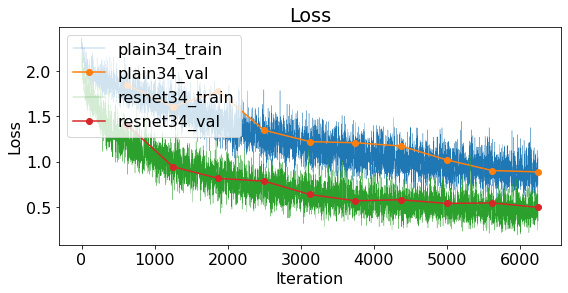

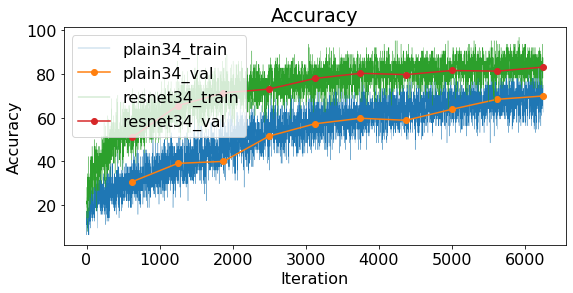

In [58]:
plt.title('Loss')
legends = []
for arch_name in arch_names:
    train_iters = range(len(hist[arch_name]['train_loss']))
    plt.plot(train_iters, hist[arch_name]['train_loss'], '-', linewidth=.3)
    legends.append(arch_name + '_train')
    plt.plot(hist[arch_name]['val_iter'], hist[arch_name]['val_loss'], '-o')
    legends.append(arch_name + '_val')
plt.legend(legends, loc='upper left')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.gcf().set_size_inches(9, 4)
plt.show()

plt.title('Accuracy')
legends = []
for arch_name in arch_names:
    train_iters = range(len(hist[arch_name]['train_acc']))
    plt.plot(train_iters, hist[arch_name]['train_acc'], '-', linewidth=.3)
    legends.append(arch_name + '_train')
    plt.plot(hist[arch_name]['val_iter'], hist[arch_name]['val_acc'], '-o')
    legends.append(arch_name + '_val')
plt.legend(legends, loc='upper left')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

## Residual Bottleneck Block

A bottleneck block is often useful for better efficiency, especially when importing a model to mobile devices.
The residual bottleneck block is similar to the standard residual block, but the plain block part has a different architecture:
it consists of three convolutional layers, and the first two convolutional layers have a smaller number of channels.

Here is the specification of the bottleneck block:

1. Spatial Batch normalization with `Cin` channels
2. ReLU
3. Conv layer (without bias) with `Cout` 1x1 filters, stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization with `Cout` channels
5. ReLU
6. Conv layer (without bias) with `Cout` 3x3 filters and zero-padding of 1
7. Spatial Batch normalization with `Cout` channels
8. ReLU
9. Conv layer (without bias) with `Cout*4` 1x1 filters

**Implement** `ResidualBottleneck.__init__`.

In [74]:
from common import count_num_layers, count_num_params
from pytorch_autograd_and_nn import ResidualBottleneck

data = torch.zeros(2, 3, 5, 6)

# Case 1: Cin == Cout, downsample=False
model = ResidualBottleneck(3, 3)
template = 'Case 1: The output dimension of ResidualBottleneck is'
if list(model(data).shape) == [2, 12, 5, 6]:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected:',
          [2, 12, 5, 6], 'got:', list(model(data).shape))

num_layers = count_num_layers(model)
template = 'Case 1: The number of layers in ResidualBottleneck is'
if num_layers == 3:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 3 got:', num_layers)

num_params = count_num_params(model)
template = 'Case 1: The number of params in ResidualBottleneck is'
if num_params == 180:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 180 got:', num_params)

# Case 2: Cin != Cout, downsample=False
model = ResidualBottleneck(3, 10)
template = 'Case 2: The output dimension of ResidualBottleneck is'
if list(model(data).shape) == [2, 40, 5, 6]:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected:',
          [2, 40, 5, 6], 'got:', list(model(data).shape))

num_layers = count_num_layers(model)
template = 'Case 2: The number of layers in ResidualBottleneck is'
if num_layers == 3:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 3 got:', num_layers)

num_params = count_num_params(model)
template = 'Case 2: The number of params in ResidualBottleneck is'
if num_params == 1496:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 1496 got:', num_params)

# Case 3: Cin != Cout, downsample=True
model = ResidualBottleneck(3, 10, downsample=True)
template = 'Case 3: The output dimension of ResidualBottleneck is'
if list(model(data).shape) == [2, 40, 3, 3]:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected:',
          [2, 40, 3, 3], 'got:', list(model(data).shape))

num_params = count_num_params(model)
template = 'Case 3: The number of params in ResidualBottleneck is'
if num_params == 1496:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 1496 got:', num_params)

num_layers = count_num_layers(model)
template = 'Case 3: The number of layers in ResidualBottleneck is'
if num_layers == 3:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 3 got:', num_layers)

Case 1: The output dimension of ResidualBottleneck is *correct*
Case 1: The number of layers in ResidualBottleneck is *correct*
Case 1: The number of params in ResidualBottleneck is *correct*
Case 2: The output dimension of ResidualBottleneck is *correct*
Case 2: The number of layers in ResidualBottleneck is *correct*
Case 2: The number of params in ResidualBottleneck is *correct*
Case 3: The output dimension of ResidualBottleneck is *correct*
Case 3: The number of params in ResidualBottleneck is *correct*
Case 3: The number of layers in ResidualBottleneck is *correct*


By running the following script, you can check the architecture of PreResNet-50 with bottlenecks.
For the sake of time, we skip training this model, but check if its forward function has no bug.

**Caution: the output is long!**

In [73]:
from common import count_num_layers

# example of specification
networks.update({
    'resnet50': {
        'block': ResidualBottleneck,
        'stage_args': [
            (16, 3, False),
            (32, 4, True),
            (64, 6, True),
            (128, 3, True),
        ],
    },
})

data = torch.zeros(2, 3, 32, 32)
model = get_resnet('resnet50')
model.eval()
if list(model(data).shape) == [2, 10]:
    print('The output dimension of resnet50 is *correct*')
else:
    print('The output dimension of resnet50 is *incorrect*; expected:',
          [2, 10], 'got:', list(model(data).shape))

num_layers = count_num_layers(model)
template = 'The number of layers in resnet50 is'
if num_layers == 50:
    print(template, '*correct*')
else:
    print(template, '*incorrect*; expected: 50 got:', num_layers)

num_params = count_num_params(model)
template = 'The number of params in resnet50 is'
if num_params == 1482266:
    print('The number of params in resnet50 is *correct*')
else:
    print('The number of params in resnet50 is *incorrect*; expected: 1482266',
          'got:', num_params)

print()
print(model)

The output dimension of resnet50 is *correct*
The number of layers in resnet50 is *correct*
The number of params in resnet50 is *correct*

ResNet(
  (cnn): Sequential(
    (0): ResNetStem(
      (net): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): ResNetStage(
      (net): Sequential(
        (0): ResidualBottleneck(
          (block): Sequential(
            (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU()
            (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (7): ReLU()
            (8): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), 

# Save Results

Once all the cells are completed, save the history of accuracies of all the parts for submission.

In [76]:
hist_dict = {}
hist_dict['hist_part1'] = hist_part1
hist_dict['hist_part2'] = hist_part2
hist_dict['hist_part3'] = hist_part3
hist_dict['hist_part4'] = hist

submission_path = os.path.join(GOOGLE_DRIVE_PATH, 'pytorch_autograd_and_nn.pt')
torch.save(hist_dict, submission_path)

# Submit Your Work
After completing the assignment, run the following cell to create a `.zip` file for you to download and turn in. Your change may not always be automatically saved, so **please MANUALLY SAVE every `*.ipynb` and `*.py` files before executing the following cell:**

In [ ]:
from common.submit import make_submission

make_submission(GOOGLE_DRIVE_PATH, 7, option, name, idnum, group)